In [1]:
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import sklearn.metrics as sklm
import math
import matplotlib.pyplot as plt
import pandas as pd #for debugging
plt.rcParams['figure.figsize'] = [8, 8]
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 17.1 Portfolio Optimization

"**Compounded portfolio value.** The cumulative value of a portfolio from a return time series vector r, starting from the traditional value of $10,000, is given by the value time series vector v, where

$$v_{t} = 10000(1+r_{1}) ... (1+r_{t-1}),\:t=1,...,T.$$

In other words, we form the *cumulative product* of the vector with entries $1+r_t$. Julia* has a built-in function that does this, **cumprod**."

*NumPy uses np.cumprod

In [2]:
#Portfolio value with re-investment, return time series r
cum_value = lambda r: 1000*np.cumprod(1 + r)
T = 250 #Days in a trading year
#Generate random returns sequence with annualized return, risk: 10%,5%
mu,sigma = .10/T, .05/np.sqrt(T)
r = mu + sigma * np.random.randn(T)
v = cum_value(r)

(1027.9700142025708, 1034.0659686948936)

Text(0.5, 0, 't')

Text(0, 0.5, 'v_t')

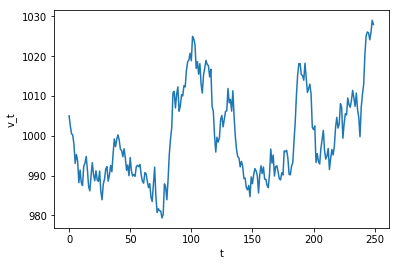

In [3]:
v[T-1], v[0]*(1+sum(r))
plt.plot(range(T),v)
plt.xlabel("t")
plt.ylabel("v_t")
#The resulting figure for some choice of r:

"**Portfolio optimization.** We define a function port_opt that evaluates the solution (17.3) of the constrained least squares problem (17.2) in VMLS, and apply to the return data in VMLS Section 17.1.3."

In [4]:
def port_opt(R,rho):
    T,n = np.shape(R)
    mu = np.vstack(np.sum(R, axis=0))/T
    a = np.hstack([2*np.matmul(R.T,R), np.ones((n,1)),mu])
    b = np.hstack([np.ones(n), 0, 0])
    c = np.block([mu.T,0,0])
    KKT = np.vstack([a,b,c])
    wz1z2 = npl.lstsq(KKT,np.vstack([2*rho*T*mu, 1, rho]))[0]
    w = wz1z2[:n]
    return w

In [5]:
R,Rtest = np.loadtxt('R.txt'), np.loadtxt('Rtest.txt')
np.shape(R), np.shape(Rtest)

((2000, 20), (500, 20))

/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


('risk and return:', 0.08650183086854815, 0.10000000000000193)

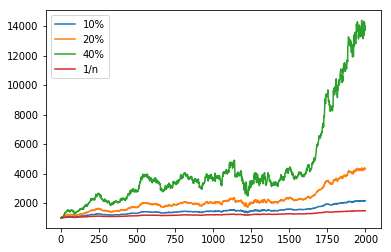

In [6]:
rho = .1/T #T from above for number of trading days, .1 for 10% annual return
w = port_opt(R,rho)
r = np.matmul(R,w) #portfolio return time series! 
pf_return = T*np.average(r)
pf_risk = np.sqrt(T)*np.std(r)
"risk and return:", pf_risk, pf_return
#Additional plots for .2,.4,1/n
plt.plot(range(np.shape(R)[0]),cum_value(r))
rho = .2/T 
w = port_opt(R,rho)
r = np.matmul(R,w)
plt.plot(range(np.shape(R)[0]),cum_value(r))
rho = .4/T 
w = port_opt(R,rho)
r = np.matmul(R,w) 
plt.plot(range(np.shape(R)[0]),cum_value(r))
rho = (1/np.shape(R)[1])/T 
w = port_opt(R,rho)
r = np.matmul(R,w) 
plt.plot(range(np.shape(R)[0]),cum_value(r))
plt.legend(["10%","20%","40%","1/n"])

# 17.2 Linear Quadratic Control

"We implement linear quadratic control, as described in VMLS 17.2, for a time-invariant system with matrices A, B, and C.

**Kronecker product.** To create the big matrices $\tilde{A}$  and $\tilde{C}$, we need to define block diagonal matrices with the same matrix repeated a number of times along the diagonal. There are many ways to do this in Julia*. One of the simplest ways uses the kron function, for the Kronecker product of two matrices. The kronecker prodcut of an m x n matrix G and a p x q matrix H is defined as the mp x nq block matrix

$$\begin{bmatrix}
    G_{11}H & G_{12}H & \dots & G_{1n}H  \\
    G_{21}H & G_{22}H & \dots & G_{2n}H \\
    \vdots & \vdots &   & \vdots \\
    G_{m1}H & G_{m2}H & \dots & G_{mn}H
\end{bmatrix}$$

It is computed in Julia as kron(G,H). If G is an n x n identity matrix, we obtain the block diagonal matrix with H repeated n times on the diagonal.
" 
 
*Numpy: np.kron

In [7]:
H = np.random.randn(2,2)
np.shape(np.kron(np.eye(3),H))
np.kron(np.eye(3),H)

(6, 6)

array([[ 0.39978553, -1.95861074,  0.        , -0.        ,  0.        ,
        -0.        ],
       [-1.32048132,  0.31163488, -0.        ,  0.        , -0.        ,
         0.        ],
       [ 0.        , -0.        ,  0.39978553, -1.95861074,  0.        ,
        -0.        ],
       [-0.        ,  0.        , -1.32048132,  0.31163488, -0.        ,
         0.        ],
       [ 0.        , -0.        ,  0.        , -0.        ,  0.39978553,
        -1.95861074],
       [-0.        ,  0.        , -0.        ,  0.        , -1.32048132,
         0.31163488]])

"An alternative method uses the Julia* cat function for constructing block matrices."

*SciPy LinAlg: spl.block_diag

In [8]:
#J: cat([H for k = 1:3]..., dims(1,2))
spl.block_diag(*[H for k in range(3)])

array([[ 0.39978553, -1.95861074,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.32048132,  0.31163488,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.39978553, -1.95861074,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -1.32048132,  0.31163488,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.39978553,
        -1.95861074],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.32048132,
         0.31163488]])

"**Linear quadratic control example.** We start by writing a function lqr that constructs and solves the constrainted least squares problem for linear quadratic control. The function returns three arrays:

```python
x = [x[1],x[2],...,x[T] ],
u = [u[1],u[2],...,u[T-1] ],
y = [y[1],y[2],...,y[T] ]
```

The first two contain the optimal solution of the problem. The third array contains $y_{t} = Cx_{t}$.

We allow the input arguments ```x_init``` and ```x_des``` to be matrices, so we can solve the same problem for different pairs of initial and end states, with one function call. If the number of columns in ```x_init``` and ```x_des``` is $q$, then the entries of the three output sequences ```x,u,y``` are matrices with $q$ columns. The $i$ th columns are the solution for the initial and end states specified in the $i$th columns of ```x_init``` and ```x_des```."

In [9]:
#"We apply the fucntion the example in 17.2.21."
A = np.array([[ 0.855,  1.161,  0.667],
       [ 0.015,  1.073,  0.053],
       [-0.084,  0.059,  1.022]])
B = np.vstack([-0.076, -.139 ,  0.342])
C = np.vstack([[ 0.218, -3.597, -1.683]])
x_init = np.vstack([ 0.496, -0.745,  1.394])
A
B
C
x_init
m,n,p = 1,3,1
x_des = np.zeros((n,1))

array([[ 0.855,  1.161,  0.667],
       [ 0.015,  1.073,  0.053],
       [-0.084,  0.059,  1.022]])

array([[-0.076],
       [-0.139],
       [ 0.342]])

array([[ 0.218, -3.597, -1.683]])

array([[ 0.496],
       [-0.745],
       [ 1.394]])

"We first plot the open-loop response of VMLS figure 17.4 in figure 17.3."

Text(0.5, 1.0, 'Figure 17.3 Open-loop response $CA^{t-1}x^{init}$')

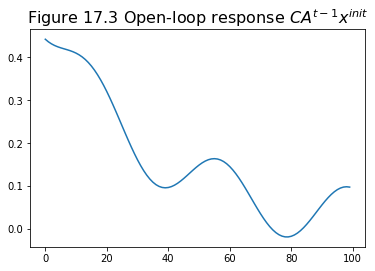

In [10]:
T = 100
yol = np.zeros((T,1))
Xol = np.hstack([x_init,np.zeros((n,T-1))])
for k in range(T-1):
    Xol[:,k+1] = np.matmul(A,Xol[:,k])
yol = np.matmul(C,Xol)
plt.plot(range(T),yol.T)
plt.title("Figure 17.3 Open-loop response $CA^{t-1}x^{init}$", fontsize=16)

"We then solve thel ienar quadratic control problem with $T$ = 100 and $p$=0.2. The result is shown in the second row of VMLS figure 177.6 and in figure 17.4 [here]." 

In [11]:
def cls_solve(A,b,C,d):
    m,n = np.shape(A)
    p,n = np.shape(C)
    Q,R = npl.qr(np.vstack([A,C]))
    Q1 = Q[0:m,:]
    Q2 = Q[m:m+p,:]
    Qtil, Rtil = npl.qr(Q2.T)
    first = np.vstack(np.matmul(np.matmul(2*Qtil.T , Q1.T),b)) #splitting line below for readability
    denom = first - np.vstack((2*(npl.lstsq(Rtil.T,d)[0]))) #splitting line below for readability
    w = npl.lstsq(Rtil, denom)[0]
    return npl.lstsq(R,np.vstack(np.matmul(Q1.T,b)) - np.matmul(Q2.T , w)/2)[0]

In [12]:
rho = .2
def lqr(A,B,C, x_init, x_des, T, rho):
    n = np.shape(A)[0]
    m = np.shape(B)[1]
    p = np.shape(C)[0]
    q = np.shape(x_init)[1]
    Atil = np.vstack([np.hstack([np.kron(np.eye(T),C), np.zeros((p*T,m*(T-1)))]),np.hstack([np.zeros((m*(T-1),n*T)), np.sqrt(rho)*np.eye(m*(T-1))])])
    btil = np.zeros((p*T + m *(T-1),q))
    Ctil11 = np.hstack([np.kron(np.eye(T-1),A), np.zeros((n*(T-1),n))]) - np.hstack([np.zeros(((n*(T-1),n))), np.eye(n*(T-1))])
    Ctil12 = np.kron(np.eye(T-1), B)
    Ctil21 = np.vstack([np.hstack([np.eye(n),np.zeros((n,n*(T-1)))]),np.hstack([np.zeros((n,n*(T-1))),np.eye(n)])])
    Ctil22 = np.zeros(((2*n),m*(T-1)))
    Ctil = np.vstack([np.hstack([Ctil11, Ctil12]),np.hstack([Ctil21, Ctil22])])
    dtil = np.vstack([np.zeros(((n*(T-1), q))), x_init, x_des])
    z = cls_solve(Atil, btil, Ctil, dtil)
    xpre = np.vstack([np.hstack(z[(i-1)*n : i*n,:]) for i in range(1,T+1)])
    x = [np.reshape(xp,(n,q)) for xp in xpre]
    u = np.vstack([np.hstack(z[n*T+(i)*m : n*T+i+1*m, :]) for i in range(0,T-1)])
    y = np.vstack([np.matmul(C,xt) for xt in x])
    return x,u,y,z

In [13]:
x,u,y,z= lqr(A,B,C,x_init,x_des,T,rho)
J_in = npl.norm(u)**2
J_out = npl.norm(y)**2
J_in
J_out

/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`

0.7738942551160236

3.7829986463324374

Text(0.5, 0, 't')

Text(0.5, 1.0, 'Figure 17.4 Optimal input and output for $p = 0.2$')

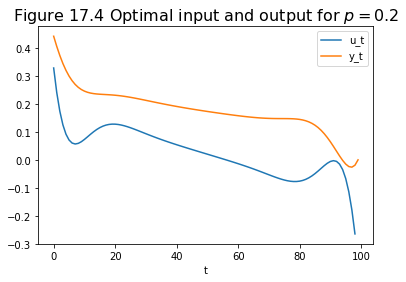

In [14]:
plt.plot(range(T-1), np.vstack(u))
plt.plot(range(T), np.vstack(y))
plt.xlabel("t")
plt.legend(["u_t","y_t"])
plt.title("Figure 17.4 Optimal input and output for $p = 0.2$", fontsize=16)

**Linear state feedback control.** To finish the example we implement the state feedback method in VMLS section 17.2.3. The plots in figure 17.5 reproduce VMLS figure 17.7."

In [15]:
def lqr(A,B,C, x_init, x_des, T, rho):
    n = np.shape(A)[0]
    m = np.shape(B)[1]
    p = np.shape(C)[0]
    q = np.shape(x_init)[1]
    Atil = np.vstack([np.hstack([np.kron(np.eye(T),C), np.zeros((p*T,m*(T-1)))]),np.hstack([np.zeros((m*(T-1),n*T)), np.sqrt(rho)*np.eye(m*(T-1))])])
    btil = np.zeros((p*T + m *(T-1),q))
    Ctil11 = np.hstack([np.kron(np.eye(T-1),A), np.zeros((n*(T-1),n))]) - np.hstack([np.zeros(((n*(T-1),n))), np.eye(n*(T-1))])
    Ctil12 = np.kron(np.eye(T-1), B)
    Ctil21 = np.vstack([np.hstack([np.eye(n),np.zeros((n,n*(T-1)))]),np.hstack([np.zeros((n,n*(T-1))),np.eye(n)])])
    Ctil22 = np.zeros(((2*n),m*(T-1)))
    Ctil = np.vstack([np.hstack([Ctil11, Ctil12]),np.hstack([Ctil21, Ctil22])])
    dtil = np.vstack([np.zeros(((n*(T-1), q))), x_init, x_des])
    z = cls_solve(Atil, btil, Ctil, dtil)
    
    xpre = np.vstack([np.hstack(z[(i-1)*n : i*n,:]) for i in range(1,T+1)])
    x = [np.reshape(xp,(n,q)) for xp in xpre]
    u = np.vstack([np.hstack(z[n*T+(i)*m : n*T+i+1*m, :]) for i in range(0,T-1)])
    y = np.vstack([np.matmul(C,xt) for xt in x])
    return x,u,y

In [16]:
#Solve LQ problem with x_init = I, x_des = 0
rho = 1.0;
n = 3
xsf,usf,ysf = lqr(A,B,C,np.eye(n),np.zeros((n,n)), T, rho)
K = usf[0]
#Simulate over horizon 150
TT = 150
Xsf = np.hstack([x_init, np.zeros((n,TT-1))])
for k in range(TT-1):
    Xsf[:,k+1] = np.matmul((A+B*K),Xsf[:,k])
usf = np.matmul(K,Xsf[:,0:TT-1])
ysf = np.matmul(C,Xsf)
#Also compute optimal LQ solution for rho = 1.0
x,u,y = lqr(A,B,C, x_init, x_des, T, rho)

/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`

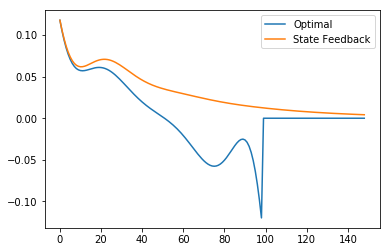

In [17]:
#Plot the two inputs
plt.plot(np.vstack([np.vstack(u), np.zeros((TT-T,1))]))
plt.plot(usf.T)
plt.legend(["Optimal", "State Feedback"])

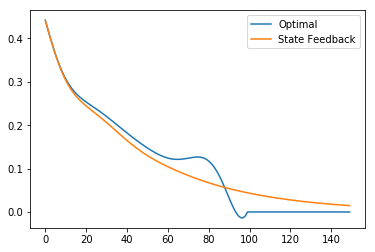

In [18]:
#Plot the two outputs
plt.plot(np.vstack([np.vstack(y), np.zeros((TT-T,1))]))
plt.plot(ysf.T)
plt.legend(["Optimal", "State Feedback"])

# 17.3 Linear Quadratic State Estimation

"The code for the linear quadratic estimation method is very similar to the one for linear quadratic control."

In [19]:
ymeas = np.array([[ 1.70778099e+01, -1.83924162e+01,  6.10394456e+00,
        -7.97507214e+00,  2.27355721e+00,  2.34308942e+01,
         3.39867360e+01,  4.24050167e+01,  2.05731680e+01,
         4.94395071e+01,  3.45442498e+01,  7.88341002e+01,
         8.67009078e+01,  7.22735074e+01,  2.31850194e+01,
         1.25784108e+02,  1.11441506e+02,  1.34603580e+02,
         9.08335516e+01,  1.39211826e+02,  1.82597858e+02,
         1.55620959e+02,  1.35394535e+02,  1.71816643e+02,
         1.79738746e+02,  2.62311327e+02,  1.65873945e+02,
         1.56867751e+02,  2.23467712e+02,  2.53129175e+02,
         2.03679219e+02,  2.20062198e+02,  2.81625929e+02,
         2.38298096e+02,  3.01005533e+02,  2.74101690e+02,
         2.41510019e+02,  2.48551509e+02,  2.25600934e+02,
         1.54680964e+02,  1.98224063e+02,  2.03866603e+02,
         2.08089219e+02,  2.08244771e+02,  1.69046465e+02,
         1.74862089e+02,  1.93984500e+02,  1.61771170e+02,
         1.44928387e+02,  1.07953687e+02,  1.42606362e+02,
         1.01143225e+02,  1.93119878e+02,  4.86121107e+01,
         1.40429785e+02,  1.16747984e+02,  7.20067571e+01,
         3.33845460e+01,  1.73703911e+00,  4.13324794e+01,
         5.10008943e+01,  7.78212231e+01,  9.73475231e+01,
         7.20156638e+00,  4.18824911e+01,  3.73829417e+01,
         1.17537300e+01,  6.50543261e+01,  7.01591558e+00,
         3.89538168e+01,  1.04449893e+02,  6.21834962e+01,
         9.85315111e+01,  5.14442316e+01,  4.75120937e+01,
         6.13570702e+01,  5.97455584e+01,  4.39494903e+01,
         8.26649843e+01,  6.08501125e+01,  1.07528400e+02,
         1.62298903e+02,  1.60557305e+02,  1.40797792e+02,
         1.39902849e+02,  1.17845958e+02,  2.00958386e+02,
         2.02880814e+02,  1.76931913e+02,  1.65895483e+02,
         2.01597849e+02,  1.98339869e+02,  2.17976883e+02,
         2.61641268e+02,  2.04828587e+02,  2.84764612e+02,
         2.22338022e+02,  2.95402558e+02,  2.60828319e+02,
         2.24987351e+02],
       [ 1.63811511e+01, -1.02102123e+00, -2.62172723e+00,
         1.70421017e+01, -8.77394913e+00, -5.20869630e+01,
        -1.60324186e+01, -4.24246849e+01, -4.91794661e+01,
        -3.06611440e+01, -1.52727993e+01, -8.11660285e+01,
        -1.16511615e+02, -1.41130660e+01, -4.61581740e+01,
        -7.50780171e+01, -1.18182293e+02, -1.29205129e+02,
        -1.64972334e+02, -1.02577288e+02, -1.22567633e+02,
        -1.81248284e+02, -1.27278951e+02, -2.04119652e+02,
        -2.27687535e+02, -2.51393552e+02, -2.74520269e+02,
        -2.66083141e+02, -3.11282088e+02, -3.05291240e+02,
        -3.87589339e+02, -4.13509577e+02, -3.79896889e+02,
        -4.66118373e+02, -4.44740533e+02, -4.57258956e+02,
        -4.92460236e+02, -4.94789750e+02, -5.42765233e+02,
        -5.26015331e+02, -5.90580789e+02, -6.21374263e+02,
        -6.17038815e+02, -6.21125522e+02, -6.39106527e+02,
        -6.94088028e+02, -7.14041092e+02, -7.35457565e+02,
        -7.26167922e+02, -7.74166470e+02, -8.35004328e+02,
        -8.56688388e+02, -8.68452776e+02, -9.07279418e+02,
        -8.85158459e+02, -9.42174345e+02, -9.96411241e+02,
        -9.31762579e+02, -1.01901698e+03, -1.09368046e+03,
        -9.92186943e+02, -1.10887128e+03, -1.11942878e+03,
        -1.18326208e+03, -1.18145562e+03, -1.14747530e+03,
        -1.19375816e+03, -1.22016814e+03, -1.22906150e+03,
        -1.28998644e+03, -1.24880527e+03, -1.30671968e+03,
        -1.36047927e+03, -1.39128750e+03, -1.37220909e+03,
        -1.39419928e+03, -1.44482396e+03, -1.47010103e+03,
        -1.42228170e+03, -1.44700843e+03, -1.49317030e+03,
        -1.55328302e+03, -1.47098557e+03, -1.54946659e+03,
        -1.55488173e+03, -1.54173960e+03, -1.56711254e+03,
        -1.59185254e+03, -1.56509343e+03, -1.60766101e+03,
        -1.65272075e+03, -1.65834577e+03, -1.56199411e+03,
        -1.64068671e+03, -1.62112540e+03, -1.63171892e+03,
        -1.66863768e+03, -1.63170753e+03, -1.65546697e+03,
        -1.64358222e+03]])

In [20]:
def cls_solve(A,b,C,d):
    m,n = np.shape(A)
    p,n = np.shape(C)
    Q,R = npl.qr(np.vstack([A,C]))
    Q1 = Q[0:m,:]
    Q2 = Q[m:m+p,:]
    Qtil, Rtil = npl.qr(Q2.T)
    first = np.vstack(np.matmul(np.matmul(2*Qtil.T , Q1.T),b)) #splitting line below for readability
    denom = first - np.vstack((2*(npl.lstsq(Rtil.T,d)[0]))) #splitting line below for readability
    w = npl.lstsq(Rtil, denom)[0]
    return npl.lstsq(R,np.vstack(np.matmul(Q1.T,b)) - np.matmul(Q2.T , w)/2)[0]


In [21]:
def lqe(A,B,C, y, T, lambd):
    n = np.shape(A)[0]
    m = np.shape(B)[1]
    p = np.shape(C)[0]
    q = np.shape(y)[1]
    Atil = np.vstack([np.hstack([np.kron(np.eye(T),C), np.zeros((T*p,m*(T-1)))])
                      ,np.hstack([np.zeros((m*(T-1),n*T)), np.sqrt(lambd)*np.eye(m*(T-1))])])
    #We assume y is a p x T array, so we vectorize it
    btil = np.vstack([np.vstack(ymeas.T.ravel()),np.zeros(((T-1)*m,1))])
    Ctila = np.hstack([np.kron(np.eye(T-1),A), np.zeros(((n*(T-1),n)))])
    Ctilb = np.hstack([np.zeros(((n*(T-1),n))), -np.eye(n*(T-1))])
    Ctil = np.hstack([Ctila + Ctilb,np.kron(np.eye(T-1),B)])
    dtil = np.zeros((n*(T-1),1))
    z = cls_solve(Atil, btil, Ctil, dtil)
    
    x = np.vstack([np.hstack(z[(i-1)*n : i*n,:]) for i in range(1,T+1)])
    u = np.vstack([z[n*T+(i)*m : n*T+i+1*m, :] for i in range(0,T-1)])
    y = np.vstack([np.matmul(C,xt) for xt in x])
    return x,u,y


/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`

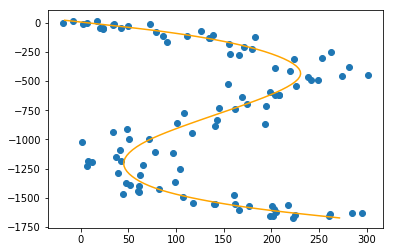

In [22]:
A = np.vstack([np.hstack([np.eye(2),np.eye(2)]),np.hstack([np.zeros((2,2)), np.eye(2)])])
B = np.vstack([np.zeros((2,2)), np.eye(2)])
C = np.hstack([np.eye(2), np.zeros((2,2))])
n = np.shape(A)[0]
m = np.shape(B)[1]
p = np.shape(C)[0]
T = 100
lambd = 1e3
xest, uest, yest = lqe(A,B,C,ymeas,T,lambd)
plt.scatter(ymeas[0,:], ymeas[1,:])
plt.plot([yt[0] for yt in yest], [yt[1] for yt in yest], "orange")

**Figure 17.6** The circles show 100 noisy measurements in 2-D. The solid line is the estimated trajectory $C\hat{x}_{t}$ for $\lambda = 1000$